# STAGE 1

In [ ]:
# If you're in Colab, you may need to install these once:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install scikit-learn

import os
import random
import numpy as np
from pathlib import Path

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import kagglehub
import warnings


In [ ]:
SEED = 429

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
path=kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'asl-alphabet' dataset.
Path to dataset files: /kaggle/input/asl-alphabet


In [ ]:
data_root=os.path.join(path, "asl_alphabet_train", "asl_alphabet_train")
TRAIN_DIR=Path(data_root)
input_size = 224  # ResNet default

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])


In [ ]:
base_train_dataset = datasets.ImageFolder(root=data_root, transform=train_transform)
num_classes = len(base_train_dataset.classes)
num_classes, base_train_dataset.classes[:10]


(29, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])

In [ ]:
class ASLSplitDataset(Dataset):
    def __init__(self, base_dataset, indices, transform=None):
        self.base = base_dataset
        self.indices = indices
        self.transform = transform
        self.samples = [self.base.samples[i] for i in indices]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = self.base.loader(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img, label


In [ ]:
indices = np.arange(len(base_train_dataset))
labels = np.array([s[1] for s in base_train_dataset.samples])

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=SEED,
)

len(train_idx), len(val_idx)


(69600, 17400)

In [ ]:
batch_size = 64

train_dataset = ASLSplitDataset(base_train_dataset, train_idx, transform=train_transform)
val_dataset   = ASLSplitDataset(base_train_dataset, val_idx,   transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:
def build_resnet18(num_classes, pretrained=True):
    """
    Returns a ResNet-18 with the classifier head replaced to match num_classes.
    Uses ImageNet weights when pretrained=True.
    """
    try:
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        model = models.resnet18(weights=weights)
    except AttributeError:
        # For older torchvision
        model = models.resnet18(pretrained=pretrained)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


In [ ]:
def set_trainable_layers(model, mode):
    """
    mode:
      'T-A': head-only
      'T-B': last block (layer4 + fc)
      'T-C': progressive: layer3 + layer4 + fc
      'S-A': from scratch (all trainable)
    """
    # start with all trainable
    for p in model.parameters():
        p.requires_grad = True

    if mode == "T-A":
        # Freeze entire backbone, train only fc
        for p in model.parameters():
            p.requires_grad = False
        for p in model.fc.parameters():
            p.requires_grad = True

    elif mode == "T-B":
        for name, p in model.named_parameters():
            if (name.startswith("conv1") or name.startswith("bn1") or
                name.startswith("layer1") or name.startswith("layer2") or
                name.startswith("layer3")):
                p.requires_grad = False
            else:
                p.requires_grad = True

    elif mode == "T-C":
        # Freeze stem + layer1 + layer2, train layer3, layer4, fc
        for name, p in model.named_parameters():
            if (name.startswith("conv1") or name.startswith("bn1") or
                name.startswith("layer1") or name.startswith("layer2")):
                p.requires_grad = False
            else:
                p.requires_grad = True

    elif mode == "S-A":
        # all trainable, but model should be built with pretrained=False for S-A
        for p in model.parameters():
            p.requires_grad = True

    else:
        raise ValueError(f"Unknown mode {mode}")

    return model


In [ ]:
def set_frozen_bn_eval(model):
    """
    For any BatchNorm layer whose parameters are all frozen (requires_grad=False),
    set the module to eval() so running stats don't update.
    """
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            all_frozen = all(not p.requires_grad for p in m.parameters())
            if all_frozen:
                m.eval()


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    set_frozen_bn_eval(model)  # important for frozen configs

    running_loss = 0.0
    y_true, y_pred = [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1  = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0
    y_true, y_pred = [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1  = f1_score(y_true, y_pred, average="macro")

    return epoch_loss, epoch_acc, epoch_f1, np.array(y_true), np.array(y_pred)


In [ ]:
def train_model_experiment(mode, num_epochs=1, base_lr=1e-3, pretrained=True,
                           train_loader=train_loader, val_loader=val_loader,
                           save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)

    if mode == "S-A":
        model = build_resnet18(num_classes, pretrained=False)
    else:
        model = build_resnet18(num_classes, pretrained=pretrained)

    model = set_trainable_layers(model, mode)
    model.to(device)

    # Only optimize trainable params
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=base_lr)
    criterion = nn.CrossEntropyLoss()

    history = {
        "train_loss": [], "train_acc": [], "train_f1": [],
        "val_loss": [],   "val_acc": [],   "val_f1": [],
    }

    best_val_f1 = -np.inf
    best_state_dict = None
    best_epoch = -1

    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_f1, y_true, y_pred = eval_one_epoch(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        print(f"[{mode}] Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss:.4f} acc: {train_acc:.4f} f1: {train_f1:.4f} | "
              f"Val loss: {val_loss:.4f} acc: {val_acc:.4f} f1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            best_state_dict = model.state_dict().copy()
            ckpt_path = os.path.join(save_dir, f"resnet18_{mode}_best.pt")
            torch.save(best_state_dict, ckpt_path)

    print(f"\nBest {mode} val macro-F1: {best_val_f1:.4f} (epoch {best_epoch+1})")
    return history, best_state_dict


In [ ]:
history_TA, state_TA = train_model_experiment(
    mode="T-A",
    num_epochs=3,
    base_lr=1e-3,
    pretrained=True,
)

[T-A] Epoch 1/3 | Train loss: 1.2674 acc: 0.7147 f1: 0.7125 | Val loss: 0.6535 acc: 0.8452 f1: 0.8451
[T-A] Epoch 2/3 | Train loss: 0.5984 acc: 0.8558 f1: 0.8554 | Val loss: 0.4624 acc: 0.8761 f1: 0.8767
[T-A] Epoch 3/3 | Train loss: 0.4577 acc: 0.8819 f1: 0.8816 | Val loss: 0.3758 acc: 0.8959 f1: 0.8957

Best T-A val macro-F1: 0.8957 (epoch 3)


In [ ]:
history_TB, state_TB = train_model_experiment(
    mode="T-B",
    num_epochs=3,
    base_lr=5e-4,
    pretrained=True,
)

[T-B] Epoch 1/3 | Train loss: 0.0997 acc: 0.9747 f1: 0.9747 | Val loss: 0.0403 acc: 0.9894 f1: 0.9894
[T-B] Epoch 2/3 | Train loss: 0.0192 acc: 0.9944 f1: 0.9944 | Val loss: 0.0169 acc: 0.9945 f1: 0.9945
[T-B] Epoch 3/3 | Train loss: 0.0129 acc: 0.9961 f1: 0.9961 | Val loss: 0.0130 acc: 0.9964 f1: 0.9964

Best T-B val macro-F1: 0.9964 (epoch 3)


In [ ]:
# Build model with pretrained backbone, load T-B best weights, then unfreeze layer3
model_TC = build_resnet18(num_classes, pretrained=True)
ckpt_TB_path = "checkpoints/resnet18_T-B_best.pt"
model_TC.load_state_dict(torch.load(ckpt_TB_path, map_location=device))

model_TC = set_trainable_layers(model_TC, "T-C")
model_TC.to(device)

params_to_update = [p for p in model_TC.parameters() if p.requires_grad]
optimizer_TC = optim.Adam(params_to_update, lr=5e-4)
criterion = nn.CrossEntropyLoss()

history_TC = {
    "train_loss": [], "train_acc": [], "train_f1": [],
    "val_loss": [],   "val_acc": [],   "val_f1": [],
}

best_val_f1 = -np.inf
best_state_TC = None
best_epoch = -1

for epoch in range(3):
    train_loss, train_acc, train_f1 = train_one_epoch(model_TC, train_loader, optimizer_TC, criterion, device)
    val_loss, val_acc, val_f1, y_true, y_pred = eval_one_epoch(model_TC, val_loader, criterion, device)

    history_TC["train_loss"].append(train_loss)
    history_TC["train_acc"].append(train_acc)
    history_TC["train_f1"].append(train_f1)
    history_TC["val_loss"].append(val_loss)
    history_TC["val_acc"].append(val_acc)
    history_TC["val_f1"].append(val_f1)

    print(f"[T-C] Epoch {epoch+1}/10 | "
          f"Train loss: {train_loss:.4f} acc: {train_acc:.4f} f1: {train_f1:.4f} | "
          f"Val loss: {val_loss:.4f} acc: {val_acc:.4f} f1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state_TC = model_TC.state_dict().copy()
        best_epoch = epoch
        torch.save(best_state_TC, "checkpoints/resnet18_T-C_best.pt")

print(f"\nBest T-C val macro-F1: {best_val_f1:.4f} (epoch {best_epoch+1})")


[T-C] Epoch 1/10 | Train loss: 0.0297 acc: 0.9910 f1: 0.9910 | Val loss: 0.0317 acc: 0.9917 f1: 0.9916
[T-C] Epoch 2/10 | Train loss: 0.0159 acc: 0.9953 f1: 0.9953 | Val loss: 0.0083 acc: 0.9978 f1: 0.9978
[T-C] Epoch 3/10 | Train loss: 0.0120 acc: 0.9965 f1: 0.9965 | Val loss: 0.0013 acc: 0.9997 f1: 0.9997

Best T-C val macro-F1: 0.9997 (epoch 3)


In [ ]:
history_SA, state_SA = train_model_experiment(
    mode="S-A",
    num_epochs=3,      # you may want more epochs from scratch
    base_lr=1e-3,
    pretrained=False,
)

[S-A] Epoch 1/3 | Train loss: 0.5950 acc: 0.8154 f1: 0.8151 | Val loss: 0.1062 acc: 0.9628 f1: 0.9622
[S-A] Epoch 2/3 | Train loss: 0.0787 acc: 0.9748 f1: 0.9748 | Val loss: 0.1122 acc: 0.9611 f1: 0.9615
[S-A] Epoch 3/3 | Train loss: 0.0482 acc: 0.9841 f1: 0.9841 | Val loss: 0.0269 acc: 0.9897 f1: 0.9896

Best S-A val macro-F1: 0.9896 (epoch 3)


In [ ]:
def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot Loss
    axes[0].plot(epochs, history["train_loss"], label="Train loss", marker='o')
    axes[0].plot(epochs, history["val_loss"], label="Val loss", marker='o')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"{title_prefix} Loss")
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(epochs, history["train_acc"], label="Train acc", marker='o')
    axes[1].plot(epochs, history["val_acc"], label="Val acc", marker='o')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title(f"{title_prefix} Accuracy")
    axes[1].legend()

    # Plot Macro-F1
    axes[2].plot(epochs, history["train_f1"], label="Train macro-F1", marker='o')
    axes[2].plot(epochs, history["val_f1"], label="Val macro-F1", marker='o')
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Macro-F1")
    axes[2].set_title(f"{title_prefix} Macro-F1")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

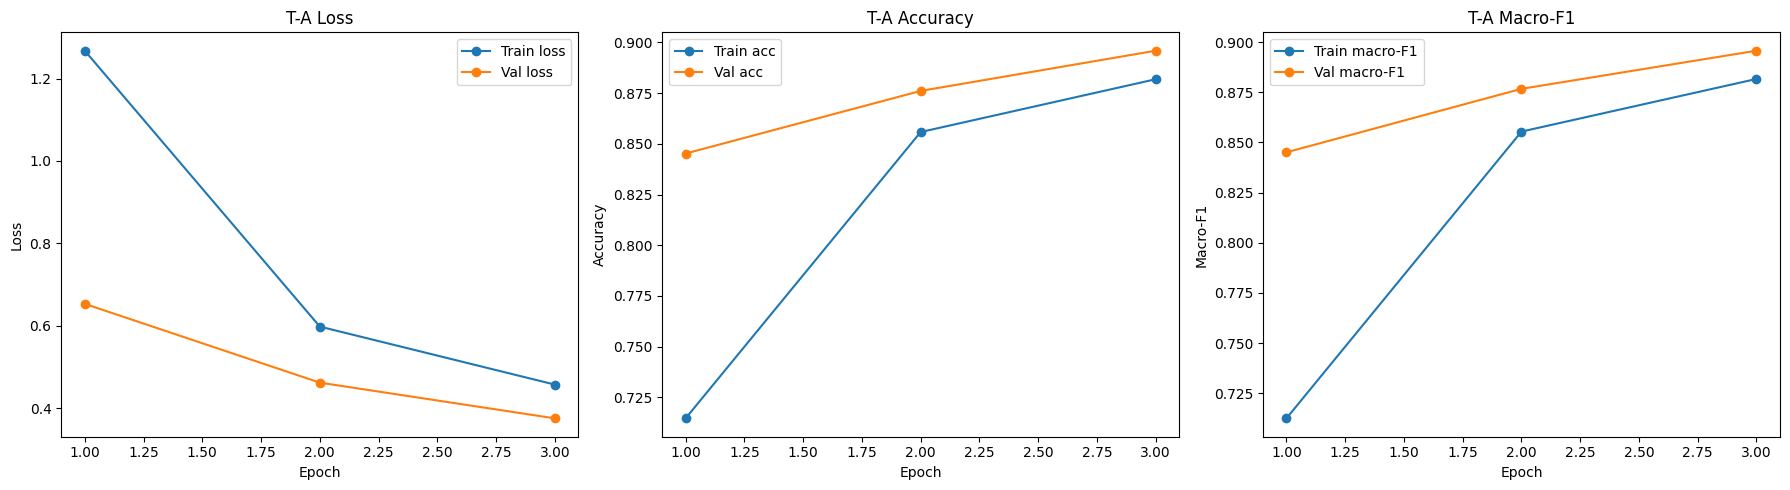

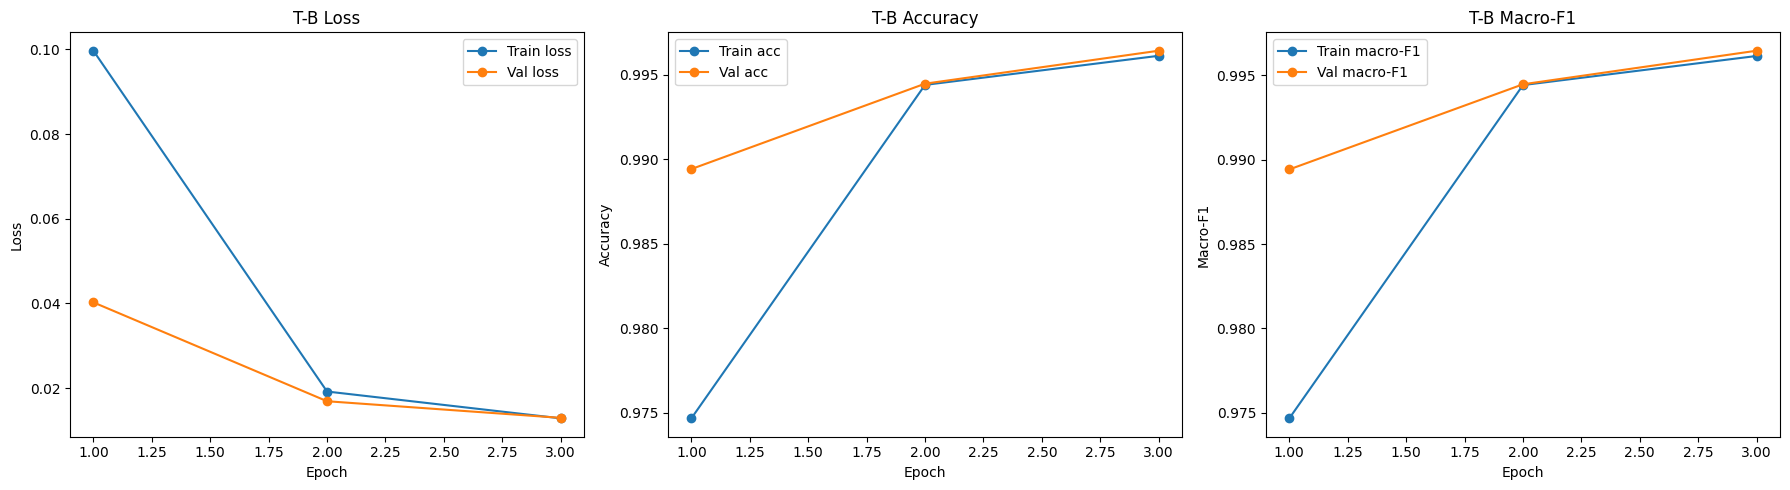

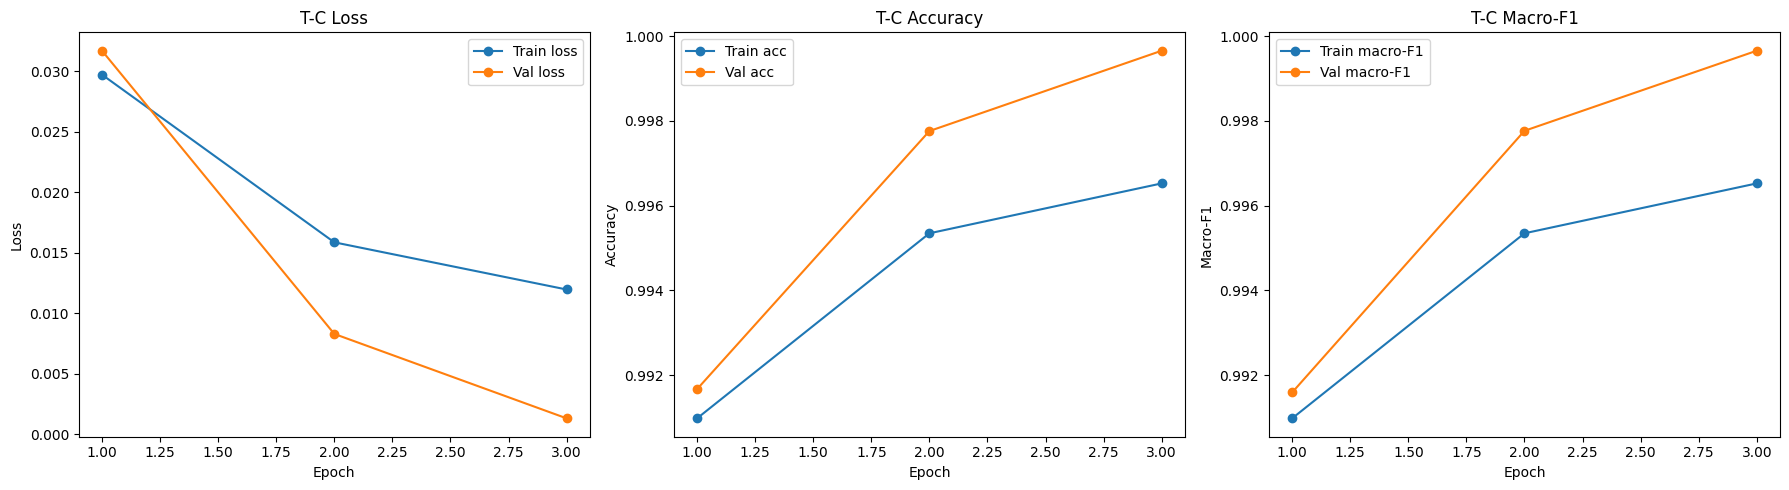

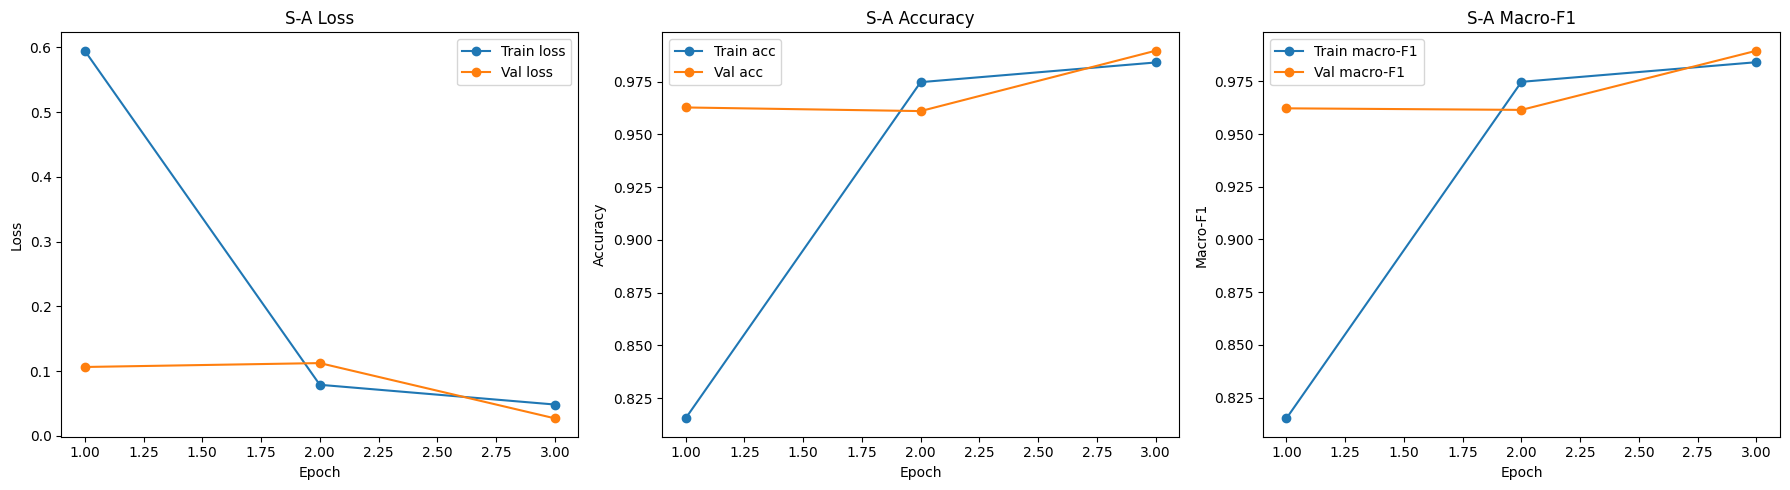

In [ ]:
plot_history(history_TA, "T-A")
plot_history(history_TB, "T-B")
plot_history(history_TC, "T-C")
plot_history(history_SA, "S-A")


In [ ]:
@torch.no_grad()
def evaluate_model_on_loader(ckpt_path, mode_name, loader):
    model = build_resnet18(num_classes, pretrained=False)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss()
    loss, acc, f1, y_true, y_pred = eval_one_epoch(model, loader, criterion, device)

    print(f"[{mode_name}] Loss: {loss:.4f}, Acc: {acc:.4f}, Macro-F1: {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

    print("\nClassification report:")
    print(classification_report(
        y_true, y_pred, target_names=base_train_dataset.classes, digits=4
    ))

    return loss, acc, f1, cm, y_true, y_pred


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path

class UnsortedImages(Dataset):
    def __init__(self, root, transform=None):
        self.root = Path(root)
        self.paths = [p for p in self.root.iterdir() if p.is_file()]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, img_path.name     # return filename instead of label

In [ ]:
MY_TEST_DIR = "/content/drive/MyDrive/my_asl_test"

my_test_dataset = UnsortedImages(MY_TEST_DIR, transform=eval_transform)
my_test_loader  = DataLoader(my_test_dataset, batch_size=32, shuffle=False)

In [ ]:
BEST_MODE = "T-C"  # or whatever actually won
BEST_CKPT = f"checkpoints/resnet18_{BEST_MODE}_best.pt"

model = build_resnet18(num_classes, pretrained=False)
model.load_state_dict(torch.load(BEST_CKPT, map_location=device))
model.to(device)
model.eval()

all_preds = []

with torch.no_grad():
    for imgs, names in my_test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(list(zip(names, preds)))

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def evaluate_phase1_confusion(ckpt_path, loader, mode_name="Phase1"):
    # Build the same architecture and load the checkpoint
    model = build_resnet18(num_classes, pretrained=False)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device)
    model.eval()

    y_true, y_pred = [], []

    for imgs, labels in loader:          # <-- loader must yield (images, labels)
        imgs  = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    print(f"[{mode_name}] confusion matrix:\n", cm)

    print("\nClassification report:")
    print(classification_report(
        y_true, y_pred, target_names=base_train_dataset.classes, digits=4
    ))

    return cm, y_true, y_pred


In [ ]:
cm_val, y_true_val, y_pred_val = evaluate_phase1_confusion(
    BEST_CKPT, val_loader, mode_name=f"{BEST_MODE} (ASL val)"
)

[T-C (ASL val)] confusion matrix:
 [[600   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 600   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 600   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 600   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 600   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 599   1   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 600   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 600   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   

In [ ]:
for name, pred in all_preds:
    print(f"{name} --> {base_train_dataset.classes[pred]}")


H.jpg --> H
W.jpg --> W
V.jpg --> V
L (1).jpg --> L
nothing.jpg --> nothing
U.jpg --> U
R.jpg --> X
space.jpg --> space
I.jpg --> I
F.jpg --> Z
G.jpg --> H
Y.jpg --> Y
C.jpg --> C
S.jpg --> S
K.jpg --> K
P.jpg --> P
B.jpg --> B
A.jpg --> A
L.jpg --> L
E.jpg --> E


# STAGE 2: BONUS


In [ ]:
results = {
    "T-A": max(history_TA["val_f1"]),
    "T-B": max(history_TB["val_f1"]),
    "T-C": max(history_TC["val_f1"]),
    "S-A": max(history_SA["val_f1"]),
}
print(results)

best_mode = max(results, key=results.get)
print("Best mode:", best_mode, "with val macro-F1 =", results[best_mode])


{'T-A': 0.8956995091480534, 'T-B': 0.9964464388932739, 'T-C': 0.9996551712164683, 'S-A': 0.9895911490161262}
Best mode: T-C with val macro-F1 = 0.9996551712164683


In [ ]:
import torch.nn as nn

class ResNetFrameEncoder(nn.Module):
    """
    Takes a Phase-1 ResNet-18 checkpoint and returns per-frame feature vectors.
    Controls freezing policy for Stage 2A / 2B.
    """
    def __init__(self, ckpt_path, num_classes, freeze_all=True, unfreeze_layer4=False):
        super().__init__()
        # Build same architecture as Phase 1 and load weights
        backbone = build_resnet18(num_classes, pretrained=False)
        state = torch.load(ckpt_path, map_location=device)
        backbone.load_state_dict(state)

        # Save blocks explicitly so we can control layer4
        self.conv1 = backbone.conv1
        self.bn1   = backbone.bn1
        self.relu  = backbone.relu
        self.maxpool = backbone.maxpool
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        self.avgpool = backbone.avgpool  # global average pooling
        self.feature_dim = 512  # ResNet-18

        # Freeze all by default
        for p in self.parameters():
            p.requires_grad = not freeze_all

        # For Stage 2B: unfreeze only layer4
        if unfreeze_layer4:
            for p in self.layer4.parameters():
                p.requires_grad = True

    def forward(self, x):   # x: (B, C, H, W)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)           # (B, 512, 1, 1)
        x = torch.flatten(x, 1)       # (B, 512)
        return x

In [ ]:
class ASLTemporalModel(nn.Module):
    def __init__(self, frame_encoder, feature_dim=512,
                 hidden_dim=256, num_layers=1, num_classes=100):
        """
        frame_encoder: ResNetFrameEncoder
        num_classes: number of WLASL word classes (100 for WLASL100 subset)
        """
        super().__init__()
        self.frame_encoder = frame_encoder
        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, frames):  # frames: (B, T, C, H, W)
        B, T, C, H, W = frames.shape
        frames = frames.view(B * T, C, H, W)

        # Encode each frame
        feats = self.frame_encoder(frames)     # (B*T, 512)
        feats = feats.view(B, T, -1)          # (B, T, 512)

        # LSTM over time
        outputs, _ = self.lstm(feats)         # (B, T, 2*hidden_dim)
        last_output = outputs[:, -1, :]       # (B, 2*hidden_dim)

        logits = self.classifier(last_output) # (B, num_classes)
        return logits


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
import numpy as np
import torch

class WLASLFramesDataset(Dataset):
    """
    Expects structure:
      root/
        class_0/
          vid_0001/
             frame_0001.jpg
             frame_0002.jpg
             ...
          vid_0002/
             ...
        class_1/
          vid_0003/
             ...
    Each 'vid_xxx' directory is treated as one sequence.
    """
    def __init__(self, root_dir, transform=None, max_frames=16):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.max_frames = max_frames

        # class folders under root_dir
        class_dirs = [d for d in self.root_dir.iterdir() if d.is_dir()]
        self.class_names = sorted(d.name for d in class_dirs)
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []  # list of (list_of_frame_paths, class_idx)

        for class_dir in class_dirs:
            cls_idx = self.class_to_idx[class_dir.name]
            # each subfolder is a video instance
            for vid_dir in class_dir.iterdir():
                if not vid_dir.is_dir():
                    continue
                frame_files = sorted(
                    list(vid_dir.glob("*.jpg")) +
                    list(vid_dir.glob("*.jpeg")) +
                    list(vid_dir.glob("*.png"))
                )
                if len(frame_files) == 0:
                    continue
                self.samples.append((frame_files, cls_idx))

        print(f"Loaded {len(self.samples)} video sequences from {self.root_dir}")
        print(f"Num classes: {len(self.class_names)}")

    def __len__(self):
        return len(self.samples)

    def _sample_or_pad_indices(self, num_frames):
        if num_frames >= self.max_frames:
            idxs = np.linspace(0, num_frames - 1, self.max_frames).astype(int)
        else:
            base = np.arange(num_frames)
            reps = int(np.ceil(self.max_frames / num_frames))
            idxs = np.tile(base, reps)[:self.max_frames]
        return idxs

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        num_frames = len(frame_paths)
        idxs = self._sample_or_pad_indices(num_frames)

        frames = []
        for i in idxs:
            img = read_image(str(frame_paths[i]))  # (C, H, W), uint8
            img = transforms.functional.convert_image_dtype(img, torch.float32)  # [0,1]
            if self.transform:
                # convert to PIL for your eval_transform
                pil = transforms.ToPILImage()(img)
                img = self.transform(pil)
            frames.append(img)

        frames_tensor = torch.stack(frames, dim=0)  # (T, C, H, W)
        return frames_tensor, label


In [ ]:
import kagglehub, os, pandas as pd

# Download latest version of the WLASL100 dataset
path = kagglehub.dataset_download("thtrnphc/wlasl100")
print("Path to dataset files:", path)

# See what's inside that folder so we know what to point to
print(os.listdir(path))


Using Colab cache for faster access to the 'wlasl100' dataset.
Path to dataset files: /kaggle/input/wlasl100
['preprocessing']


In [ ]:
pre_path = os.path.join(path, "preprocessing")
print("preprocessing contains:", os.listdir(pre_path))


preprocessing contains: ['val', 'test', 'train']


In [ ]:
import os
from pathlib import Path

path = '/kaggle/input/wlasl100'

pre_path = os.path.join(path, "preprocessing")

WLASL_TRAIN_FRAMES_ROOT = os.path.join(pre_path, "train", "frames")
WLASL_VAL_FRAMES_ROOT   = os.path.join(pre_path, "val",   "frames")
WLASL_TEST_FRAMES_ROOT  = os.path.join(pre_path, "test",  "frames")

print("Train frames root:", WLASL_TRAIN_FRAMES_ROOT)
print("Sample class dirs:", os.listdir(WLASL_TRAIN_FRAMES_ROOT)[:5])

Train frames root: /kaggle/input/wlasl100/preprocessing/train/frames
Sample class dirs: ['medicine', 'no', 'many', 'orange', 'dance']


In [ ]:
wlasl_train_dataset = WLASLFramesDataset(
    WLASL_TRAIN_FRAMES_ROOT, transform=eval_transform, max_frames=16
)
wlasl_val_dataset = WLASLFramesDataset(
    WLASL_VAL_FRAMES_ROOT, transform=eval_transform, max_frames=16
)
wlasl_test_dataset = WLASLFramesDataset(
    WLASL_TEST_FRAMES_ROOT, transform=eval_transform, max_frames=16
)

num_wlasl_classes = len(wlasl_train_dataset.class_names)
print("Num WLASL classes:", num_wlasl_classes)

wlasl_train_loader = DataLoader(
    wlasl_train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True
)
wlasl_val_loader = DataLoader(
    wlasl_val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True
)
wlasl_test_loader = DataLoader(
    wlasl_test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True
)



Loaded 1440 video sequences from /kaggle/input/wlasl100/preprocessing/train/frames
Num classes: 100
Loaded 337 video sequences from /kaggle/input/wlasl100/preprocessing/val/frames
Num classes: 100
Loaded 258 video sequences from /kaggle/input/wlasl100/preprocessing/test/frames
Num classes: 100
Num WLASL classes: 100


In [ ]:
frames, labels = next(iter(wlasl_train_loader))
print(frames.shape)   # should be (B, T, C, H, W)
print(labels.shape)



torch.Size([8, 16, 3, 224, 224])
torch.Size([8])


In [ ]:
BEST_MODE = "T-B"  # or whatever actually won
BEST_CKPT = f"checkpoints/resnet18_{BEST_MODE}_best.pt"



In [ ]:
def train_one_epoch_temporal(model, loader, optimizer, criterion, device):
    model.train()
    set_frozen_bn_eval(model)  # still useful for frozen parts of ResNet

    running_loss = 0.0
    y_true, y_pred = [], []

    for frames, labels in loader:
        frames = frames.to(device)   # (B, T, C, H, W)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)

        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1  = f1_score(y_true, y_pred, average="macro")
    return epoch_loss, epoch_acc, epoch_f1


@torch.no_grad()
def eval_one_epoch_temporal(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0
    y_true, y_pred = [], []

    for frames, labels in loader:
        frames = frames.to(device)
        labels = labels.to(device)

        outputs = model(frames)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * frames.size(0)

        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(y_true, y_pred)
    epoch_f1  = f1_score(y_true, y_pred, average="macro")
    return epoch_loss, epoch_acc, epoch_f1, np.array(y_true), np.array(y_pred)


In [ ]:
def run_stage_2A(num_epochs=10, base_lr=1e-3, num_wlasl_classes=100):
    # Frame encoder: freeze all CNN parameters
    frame_encoder_2A = ResNetFrameEncoder(
        ckpt_path=BEST_CKPT,
        num_classes=num_classes,      # from Phase 1 ASL, e.g., 29
        freeze_all=True,
        unfreeze_layer4=False
    )

    model_2A = ASLTemporalModel(
        frame_encoder=frame_encoder_2A,
        feature_dim=512,
        hidden_dim=256,
        num_layers=1,
        num_classes=num_wlasl_classes
    ).to(device)

    # Only parameters that require grad are the LSTM + classifier
    params_to_update = [p for p in model_2A.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=base_lr)
    criterion = nn.CrossEntropyLoss()

    history_2A = {"train_loss": [], "train_acc": [], "train_f1": [],
                  "val_loss": [],   "val_acc": [],   "val_f1": []}

    best_val_f1 = -np.inf
    best_state_2A = None

    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1 = train_one_epoch_temporal(
            model_2A, wlasl_train_loader, optimizer, criterion, device
        )
        val_loss, val_acc, val_f1, _, _ = eval_one_epoch_temporal(
            model_2A, wlasl_val_loader, criterion, device
        )

        history_2A["train_loss"].append(train_loss)
        history_2A["train_acc"].append(train_acc)
        history_2A["train_f1"].append(train_f1)
        history_2A["val_loss"].append(val_loss)
        history_2A["val_acc"].append(val_acc)
        history_2A["val_f1"].append(val_f1)

        print(f"[2A] Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f}, f1: {train_f1:.4f} | "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state_2A = model_2A.state_dict().copy()
            torch.save(best_state_2A, "checkpoints/temporal_stage2A_best.pt")

    print(f"\nBest Stage 2A val macro-F1: {best_val_f1:.4f}")
    return history_2A, best_state_2A


In [ ]:
def run_stage_2B(num_epochs=10, base_lr=5e-4, num_wlasl_classes=100):
    frame_encoder_2B = ResNetFrameEncoder(
        ckpt_path=BEST_CKPT,
        num_classes=num_classes,
        freeze_all=True,
        unfreeze_layer4=True   # <--- only layer4 trainable in the CNN
    )

    model_2B = ASLTemporalModel(
        frame_encoder=frame_encoder_2B,
        feature_dim=512,
        hidden_dim=256,
        num_layers=1,
        num_classes=num_wlasl_classes
    ).to(device)

    params_to_update = [p for p in model_2B.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=base_lr)
    criterion = nn.CrossEntropyLoss()

    history_2B = {"train_loss": [], "train_acc": [], "train_f1": [],
                  "val_loss": [],   "val_acc": [],   "val_f1": []}

    best_val_f1 = -np.inf
    best_state_2B = None

    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1 = train_one_epoch_temporal(
            model_2B, wlasl_train_loader, optimizer, criterion, device
        )
        val_loss, val_acc, val_f1, _, _ = eval_one_epoch_temporal(
            model_2B, wlasl_val_loader, criterion, device
        )

        history_2B["train_loss"].append(train_loss)
        history_2B["train_acc"].append(train_acc)
        history_2B["train_f1"].append(train_f1)
        history_2B["val_loss"].append(val_loss)
        history_2B["val_acc"].append(val_acc)
        history_2B["val_f1"].append(val_f1)

        print(f"[2B] Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f}, f1: {train_f1:.4f} | "
              f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state_2B = model_2B.state_dict().copy()
            torch.save(best_state_2B, "checkpoints/temporal_stage2B_best.pt")

    print(f"\nBest Stage 2B val macro-F1: {best_val_f1:.4f}")
    return history_2B, best_state_2B


In [ ]:
#history_2A, state_2A = run_stage_2A(
#    num_epochs=5,
#    base_lr=1e-3,
#    num_wlasl_classes=num_wlasl_classes
#)

history_2B, state_2B = run_stage_2B(
    num_epochs=8,
    base_lr=5e-4,
    num_wlasl_classes=100
)


[2B] Epoch 1/8 | Train loss: 4.4608, acc: 0.0319, f1: 0.0123 | Val loss: 4.1137, acc: 0.0742, f1: 0.0202
[2B] Epoch 2/8 | Train loss: 3.8427, acc: 0.0903, f1: 0.0481 | Val loss: 3.6364, acc: 0.1276, f1: 0.0656
[2B] Epoch 3/8 | Train loss: 3.3314, acc: 0.1535, f1: 0.1070 | Val loss: 3.4603, acc: 0.1454, f1: 0.0999
[2B] Epoch 4/8 | Train loss: 2.8194, acc: 0.2597, f1: 0.2165 | Val loss: 3.2558, acc: 0.1721, f1: 0.1310
[2B] Epoch 5/8 | Train loss: 2.3427, acc: 0.3632, f1: 0.3147 | Val loss: 3.2247, acc: 0.2107, f1: 0.1809
[2B] Epoch 6/8 | Train loss: 1.8695, acc: 0.5007, f1: 0.4660 | Val loss: 3.2058, acc: 0.2344, f1: 0.1936
[2B] Epoch 7/8 | Train loss: 1.3491, acc: 0.6465, f1: 0.6219 | Val loss: 3.1664, acc: 0.2374, f1: 0.2023
[2B] Epoch 8/8 | Train loss: 0.9110, acc: 0.7819, f1: 0.7701 | Val loss: 3.3572, acc: 0.2611, f1: 0.2364

Best Stage 2B val macro-F1: 0.2364


In [ ]:
@torch.no_grad()
def evaluate_temporal_checkpoint(ckpt_path, num_wlasl_classes, loader, mode_name="Stage2"):
    # Build frame encoder with the same structure; we only need forward, so we can freeze_all=True
    frame_encoder = ResNetFrameEncoder(
        ckpt_path=BEST_CKPT,
        num_classes=num_classes,
        freeze_all=True,
        unfreeze_layer4=False
    )

    model = ASLTemporalModel(
        frame_encoder=frame_encoder,
        feature_dim=512,
        hidden_dim=256,
        num_layers=1,
        num_classes=num_wlasl_classes
    ).to(device)

    # Load temporal weights
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)

    criterion = nn.CrossEntropyLoss()
    loss, acc, f1, y_true, y_pred = eval_one_epoch_temporal(model, loader, criterion, device)

    print(f"[{mode_name}] Test loss: {loss:.4f}, acc: {acc:.4f}, macro-F1: {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))

    return loss, acc, f1, cm, y_true, y_pred


In [ ]:
# pick 2B because it clearly beats 2A
BEST_STAGE2_CKPT = "checkpoints/temporal_stage2B_best.pt"

test_loss, test_acc, test_f1, test_cm, y_true_test, y_pred_test = evaluate_temporal_checkpoint(
    BEST_STAGE2_CKPT,
    num_wlasl_classes=num_wlasl_classes,
    loader=wlasl_test_loader,
    mode_name="Stage 2B"
)


[Stage 2B] Test loss: 3.1981, acc: 0.2752, macro-F1: 0.2228
Confusion matrix:
 [[0 0 0 ... 1 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         3
           1     0.3333    0.6667    0.4444         3
           2     0.0000    0.0000    0.0000         3
           3     0.5000    0.5000    0.5000         2
           4     0.5000    1.0000    0.6667         2
           5     0.0000    0.0000    0.0000         2
           6     0.0909    0.2500    0.1333         4
           7     0.0000    0.0000    0.0000         2
           8     0.0000    0.0000    0.0000         3
           9     0.5000    0.6667    0.5714         3
          10     0.0000    0.0000    0.0000         2
          11     1.0000    0.7500    0.8571         4
          12     0.0000    0.0000    0.0000         2
          13     0.0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
